In [1]:
import numpy as onp
import jax.numpy as np
from jax import random, vmap
from jax.config import config
config.update("jax_enable_x64", True)

from scipy.optimize import minimize
from pyDOE import lhs
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.interpolate import griddata

from jaxbo.mcmc_models import BayesianMLP
from jaxbo.utils import normalize, compute_w_gmm
from jaxbo.test_functions import *

onp.random.seed(1234)

In [2]:
# Define test function
f, p_x, dim, lb, ub = oakley()

# Problem settings
N = 5
noise = 0.0
options = {'kernel': None,
           'criterion': 'LW-LCB', 
           'input_prior': p_x,
           'kappa': 2.0,
           'nIter': 20}
mcmc_settings = {'num_warmup': 500,
                 'num_samples': 1000,
                 'num_chains': 1,
                 'target_accept_prob': 0.9}
layers = [dim, 10, 10, 1]
bnn_model = BayesianMLP(options, layers)

# Fetch domain bounds
bounds = {'lb': lb, 'ub': ub}

# Initial training data
X = lb + (ub-lb)*lhs(dim, N)
y = vmap(f)(X)
y = y + noise*y.std(0)*onp.random.normal(y.shape)

# Test data
if dim == 1:
    create_plots = True
    nn = 1000
    X_star = np.linspace(lb[0], ub[0], nn)[:,None]
    y_star = vmap(f)(X_star)
elif dim == 2:
    create_plots = True
    nn = 80
    xx = np.linspace(lb[0], ub[0], nn)
    yy = np.linspace(lb[1], ub[1], nn)
    XX, YY = np.meshgrid(xx, yy)
    X_star = np.concatenate([XX.flatten()[:,None], 
                             YY.flatten()[:,None]], axis = 1)
    y_star = vmap(f)(X_star)
else:
    create_plots = False
    nn = 20000
    X_star = lb + (ub-lb)*lhs(dim, nn)
    y_star = vmap(f)(X_star)

# True location of global minimum
idx_true = np.argmin(y_star)
true_x = X_star[idx_true,:]
true_y = y_star.min()
dom_bounds = tuple(map(tuple, np.vstack((lb, ub)).T))
result = minimize(f, true_x, jac=None, method='L-BFGS-B', bounds = dom_bounds)
true_x, true_y = result.x, result.fun

In [6]:
# Main Bayesian optimization loop
rng_key = random.PRNGKey(0)
for it in range(options['nIter']):
    print('-------------------------------------------------------------------')
    print('------------------------- Iteration %d/%d -------------------------' % (it+1, options['nIter']))
    print('-------------------------------------------------------------------')

    # Fetch normalized training data
    norm_batch, norm_const = normalize(X, y)

    # Train BNN model
    print('Train BNN...')
    key1, key2 = random.split(rng_key)
    samples = bnn_model.train(norm_batch,
                              key1,
                              mcmc_settings)
    rng_keys = random.split(key2, 
                            mcmc_settings['num_samples'] * mcmc_settings['num_chains'])

    # Fit GMM
    if options['criterion'] == 'LW-LCB' or options['criterion'] == 'LW-US':
        print('Fit GMM...')
        rng_key = random.split(rng_key)[0]
        kwargs = {'samples': samples,
                  'rng_keys': rng_keys,
                  'batch': norm_batch,
                  'norm_const': norm_const,
                  'bounds': bounds,
                  'rng_key': rng_key}
        gmm_vars = bnn_model.fit_gmm(**kwargs, N_samples = 10000)
    else:
        gmm_vars = None

    print('Computing next acquisition point...')
    kwargs = {'samples': samples,
              'rng_keys': rng_keys,
              'batch': norm_batch,
              'norm_const': norm_const,
              'bounds': bounds,
              'gmm_vars': gmm_vars}
    new_X = bnn_model.compute_next_point(num_restarts=10, **kwargs)

    # Acquire data
    new_y = vmap(f)(new_X)
    new_y = new_y + noise*new_y.std(0)*onp.random.normal(new_y.shape)

    # Augment training data
    print('Updating data-set...')
    X = np.concatenate([X, new_X], axis = 0)
    y = np.concatenate([y, new_y], axis = 0)

    # Print current best
    idx_best = np.argmin(y)
    best_x = X[idx_best,:]
    best_y = y.min()
    print('True location: (%f,%f), True value: %f' % (true_x[0], true_x[1], true_y))
    print('Best location: (%f,%f), Best value: %f' % (best_x[0], best_x[1], best_y))
    print('New  location: (%f,%f), New  value: %f' % (new_X[0,0], new_X[0,1], new_y))

-------------------------------------------------------------------
------------------------- Iteration 1/20 -------------------------
-------------------------------------------------------------------
Train BNN...


sample: 100%|██████████| 1500/1500 [00:20<00:00, 73.38it/s, 1023 steps of size 2.51e-04. acc. prob=0.91] 


Fit GMM...
Computing next acquisition point...
Updating data-set...
True location: (-3.665193,-2.094395), True value: -4.223688
Best location: (-3.693569,-1.143426), Best value: -3.360093
New  location: (-0.866573,-0.514086), New  value: 3.930747
-------------------------------------------------------------------
------------------------- Iteration 2/20 -------------------------
-------------------------------------------------------------------
Train BNN...


sample: 100%|██████████| 1500/1500 [00:18<00:00, 80.39it/s, 1023 steps of size 9.07e-04. acc. prob=0.78] 


Fit GMM...
Computing next acquisition point...
Updating data-set...
True location: (-3.665193,-2.094395), True value: -4.223688
Best location: (-3.693569,-1.143426), Best value: -3.360093
New  location: (0.306876,0.455696), New  value: 8.549312
-------------------------------------------------------------------
------------------------- Iteration 3/20 -------------------------
-------------------------------------------------------------------
Train BNN...


sample: 100%|██████████| 1500/1500 [00:20<00:00, 72.09it/s, 1023 steps of size 1.36e-04. acc. prob=0.98] 


Fit GMM...
Computing next acquisition point...
Updating data-set...
True location: (-3.665193,-2.094395), True value: -4.223688
Best location: (-3.693569,-1.143426), Best value: -3.360093
New  location: (-0.422525,-0.954638), New  value: 3.814740
-------------------------------------------------------------------
------------------------- Iteration 4/20 -------------------------
-------------------------------------------------------------------
Train BNN...


sample: 100%|██████████| 1500/1500 [00:19<00:00, 77.33it/s, 143 steps of size 6.24e-04. acc. prob=0.80]  


Fit GMM...
Computing next acquisition point...
Updating data-set...
True location: (-3.665193,-2.094395), True value: -4.223688
Best location: (-3.693569,-1.143426), Best value: -3.360093
New  location: (0.273789,0.648614), New  value: 9.056074
-------------------------------------------------------------------
------------------------- Iteration 5/20 -------------------------
-------------------------------------------------------------------
Train BNN...


sample: 100%|██████████| 1500/1500 [00:19<00:00, 77.98it/s, 8 steps of size 6.11e-04. acc. prob=0.76]    


Fit GMM...
Computing next acquisition point...
Updating data-set...
True location: (-3.665193,-2.094395), True value: -4.223688
Best location: (-3.693569,-1.143426), Best value: -3.360093
New  location: (-2.501570,-1.266200), New  value: -2.279869
-------------------------------------------------------------------
------------------------- Iteration 6/20 -------------------------
-------------------------------------------------------------------
Train BNN...


sample: 100%|██████████| 1500/1500 [00:21<00:00, 68.57it/s, 1023 steps of size 6.04e-04. acc. prob=0.80] 


Fit GMM...
Computing next acquisition point...
Updating data-set...
True location: (-3.665193,-2.094395), True value: -4.223688
Best location: (-3.693569,-1.143426), Best value: -3.360093
New  location: (-1.739091,-1.101179), New  value: 0.041244
-------------------------------------------------------------------
------------------------- Iteration 7/20 -------------------------
-------------------------------------------------------------------
Train BNN...


sample: 100%|██████████| 1500/1500 [00:23<00:00, 64.08it/s, 1023 steps of size 3.96e-04. acc. prob=0.96]


Fit GMM...
Computing next acquisition point...
Updating data-set...
True location: (-3.665193,-2.094395), True value: -4.223688
Best location: (-3.693569,-1.143426), Best value: -3.360093
New  location: (1.064762,0.769226), New  value: 9.194571
-------------------------------------------------------------------
------------------------- Iteration 8/20 -------------------------
-------------------------------------------------------------------
Train BNN...


sample: 100%|██████████| 1500/1500 [00:21<00:00, 71.14it/s, 1023 steps of size 6.52e-04. acc. prob=0.79] 


Fit GMM...
Computing next acquisition point...
Updating data-set...
True location: (-3.665193,-2.094395), True value: -4.223688
Best location: (-3.693569,-1.143426), Best value: -3.360093
New  location: (-2.068871,-0.804987), New  value: -0.270972
-------------------------------------------------------------------
------------------------- Iteration 9/20 -------------------------
-------------------------------------------------------------------
Train BNN...


sample: 100%|██████████| 1500/1500 [00:22<00:00, 66.96it/s, 1023 steps of size 1.11e-04. acc. prob=0.95] 


Fit GMM...
Computing next acquisition point...
Updating data-set...
True location: (-3.665193,-2.094395), True value: -4.223688
Best location: (-3.693569,-1.143426), Best value: -3.360093
New  location: (-4.000000,-4.000000), New  value: -2.793682
-------------------------------------------------------------------
------------------------- Iteration 10/20 -------------------------
-------------------------------------------------------------------
Train BNN...


sample: 100%|██████████| 1500/1500 [00:25<00:00, 58.62it/s, 6 steps of size 1.13e-04. acc. prob=0.90]    


Fit GMM...
Computing next acquisition point...
Updating data-set...
True location: (-3.665193,-2.094395), True value: -4.223688
Best location: (-3.693569,-1.143426), Best value: -3.360093
New  location: (-1.447416,2.434358), New  value: 7.532544
-------------------------------------------------------------------
------------------------- Iteration 11/20 -------------------------
-------------------------------------------------------------------
Train BNN...


sample: 100%|██████████| 1500/1500 [00:21<00:00, 68.20it/s, 340 steps of size 5.06e-04. acc. prob=0.68]  


Fit GMM...
Computing next acquisition point...
Updating data-set...
True location: (-3.665193,-2.094395), True value: -4.223688
Best location: (-3.693569,-1.143426), Best value: -3.360093
New  location: (-0.554467,1.071645), New  value: 8.973518
-------------------------------------------------------------------
------------------------- Iteration 12/20 -------------------------
-------------------------------------------------------------------
Train BNN...


sample: 100%|██████████| 1500/1500 [00:25<00:00, 59.94it/s, 1023 steps of size 6.33e-05. acc. prob=0.94]


Fit GMM...
Computing next acquisition point...
Updating data-set...
True location: (-3.665193,-2.094395), True value: -4.223688
Best location: (-3.693569,-1.143426), Best value: -3.360093
New  location: (-2.055595,-1.051643), New  value: -0.775776
-------------------------------------------------------------------
------------------------- Iteration 13/20 -------------------------
-------------------------------------------------------------------
Train BNN...


sample: 100%|██████████| 1500/1500 [00:23<00:00, 64.41it/s, 5 steps of size 3.39e-04. acc. prob=0.66]   


Fit GMM...
Computing next acquisition point...
Updating data-set...
True location: (-3.665193,-2.094395), True value: -4.223688
Best location: (-3.693569,-1.143426), Best value: -3.360093
New  location: (-1.523710,-1.983531), New  value: -0.245158
-------------------------------------------------------------------
------------------------- Iteration 14/20 -------------------------
-------------------------------------------------------------------
Train BNN...


sample: 100%|██████████| 1500/1500 [00:29<00:00, 51.53it/s, 1023 steps of size 3.60e-04. acc. prob=0.85] 


Fit GMM...
Computing next acquisition point...
Updating data-set...
True location: (-3.665193,-2.094395), True value: -4.223688
Best location: (-3.693569,-1.143426), Best value: -3.360093
New  location: (-0.239552,-0.902934), New  value: 4.230108
-------------------------------------------------------------------
------------------------- Iteration 15/20 -------------------------
-------------------------------------------------------------------
Train BNN...


sample: 100%|██████████| 1500/1500 [00:30<00:00, 49.96it/s, 1023 steps of size 4.64e-04. acc. prob=0.82] 


Fit GMM...
Computing next acquisition point...
Updating data-set...
True location: (-3.665193,-2.094395), True value: -4.223688
Best location: (-3.693569,-1.143426), Best value: -3.360093
New  location: (-1.584161,-0.792951), New  value: 1.171303
-------------------------------------------------------------------
------------------------- Iteration 16/20 -------------------------
-------------------------------------------------------------------
Train BNN...


sample: 100%|██████████| 1500/1500 [00:27<00:00, 54.59it/s, 1023 steps of size 5.49e-04. acc. prob=0.82] 


Fit GMM...
Computing next acquisition point...
Updating data-set...
True location: (-3.665193,-2.094395), True value: -4.223688
Best location: (-3.693569,-1.143426), Best value: -3.360093
New  location: (0.268388,-0.529406), New  value: 5.657341
-------------------------------------------------------------------
------------------------- Iteration 17/20 -------------------------
-------------------------------------------------------------------
Train BNN...


sample: 100%|██████████| 1500/1500 [00:25<00:00, 59.41it/s, 10 steps of size 3.63e-04. acc. prob=0.71]   


Fit GMM...
Computing next acquisition point...
Updating data-set...
True location: (-3.665193,-2.094395), True value: -4.223688
Best location: (-3.693569,-1.143426), Best value: -3.360093
New  location: (-2.217677,-1.561827), New  value: -1.984824
-------------------------------------------------------------------
------------------------- Iteration 18/20 -------------------------
-------------------------------------------------------------------
Train BNN...


sample: 100%|██████████| 1500/1500 [00:28<00:00, 51.96it/s, 1023 steps of size 1.72e-04. acc. prob=0.78] 


Fit GMM...
Computing next acquisition point...
Updating data-set...
True location: (-3.665193,-2.094395), True value: -4.223688
Best location: (-3.693569,-1.143426), Best value: -3.360093
New  location: (-0.956972,-0.754781), New  value: 3.069985
-------------------------------------------------------------------
------------------------- Iteration 19/20 -------------------------
-------------------------------------------------------------------
Train BNN...


sample: 100%|██████████| 1500/1500 [00:32<00:00, 45.52it/s, 1023 steps of size 5.55e-04. acc. prob=0.85]


Fit GMM...
Computing next acquisition point...
Updating data-set...
True location: (-3.665193,-2.094395), True value: -4.223688
Best location: (-3.693569,-1.143426), Best value: -3.360093
New  location: (2.757416,-1.474490), New  value: 2.437979
-------------------------------------------------------------------
------------------------- Iteration 20/20 -------------------------
-------------------------------------------------------------------
Train BNN...


sample: 100%|██████████| 1500/1500 [00:32<00:00, 45.58it/s, 1023 steps of size 6.69e-05. acc. prob=0.95]


Fit GMM...
Computing next acquisition point...
Updating data-set...
True location: (-3.665193,-2.094395), True value: -4.223688
Best location: (-3.693569,-1.143426), Best value: -3.360093
New  location: (0.474905,-0.239666), New  value: 6.539155


In [7]:
# Test accuracy
mean, std = bnn_model.predict(X_star, **kwargs)
lower = mean - 2.0*std
upper = mean + 2.0*std
# Check accuracy
error = np.linalg.norm(mean-y_star,2)/np.linalg.norm(y_star,2)
print("Relative L2 error u: %e" % (error))

Relative L2 error u: 6.036071e-01


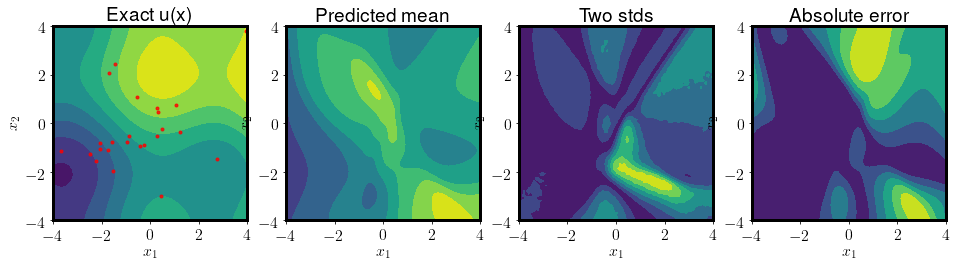

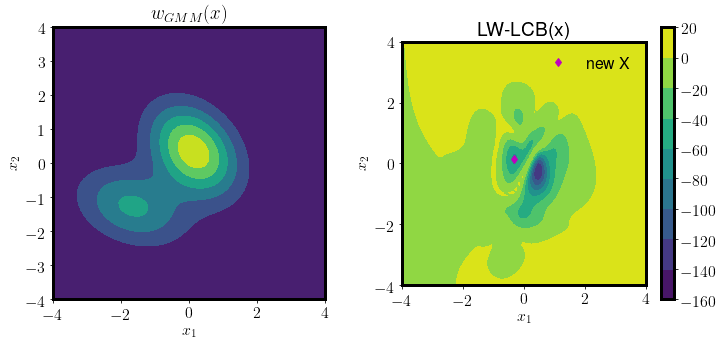

In [8]:
if create_plots:
    # Compute predictions
    if options['criterion'] == 'LW-LCB' or options['criterion'] == 'LW-US':
        w_pred = compute_w_gmm(X_star, **kwargs)
    else:
        w_pred = np.zeros(X_star.shape[0])
        
    acq_fun = lambda x: bnn_model.acquisition(x, **kwargs)
    a_pred = vmap(acq_fun)(X_star)
    x_new = bnn_model.compute_next_point(num_restarts=10, **kwargs)

    # Convert to NumPy
    X_star = onp.array(X_star)
    y_star = onp.array(y_star)
    mean = onp.array(mean)
    std = onp.array(std)
    w_pred = onp.array(w_pred)
    a_pred = onp.array(a_pred)
    XX = onp.array(XX)
    YY = onp.array(YY)
    Y_star = griddata(X_star, y_star, (XX, YY), method='cubic')
    Y_pred = griddata(X_star, mean, (XX, YY), method='cubic')
    Y_std  = griddata(X_star, std, (XX, YY), method='cubic')
    W_star = griddata(X_star, w_pred, (XX, YY), method='cubic')
    A_star = griddata(X_star, a_pred, (XX, YY), method='cubic')

    # Plot
    plt.rcParams.update({'font.size': 16})
    plt.rcParams['axes.linewidth']=3
    rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
    rc('text', usetex=True)

    plt.figure(figsize = (16,8))
    plt.subplot(1, 4, 1)
    fig = plt.contourf(XX, YY, Y_star)
    plt.plot(X[:,0], X[:,1], 'r.', ms = 6, alpha = 0.8)
    # plt.plot(true_x[0], true_x[1], 'md', ms = 8, alpha = 1.0)
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.title(r'Exact u(x)')
    plt.axis('square')

    plt.subplot(1, 4, 2)
    fig = plt.contourf(XX, YY, Y_pred)
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.title(r'Predicted mean')
    plt.axis('square')

    plt.subplot(1, 4, 3)
    fig = plt.contourf(XX, YY, 2.0*Y_std)
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.title(r'Two stds')
    plt.axis('square')

    plt.subplot(1, 4, 4)
    fig = plt.contourf(XX, YY, np.abs(Y_star-Y_pred))
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.title(r'Absolute error')
    plt.axis('square')
#     plt.savefig('function_prediction.png', dpi = 300)

    idx_max = np.argmin(a_pred)
    plt.figure(figsize = (12,5))
    plt.subplot(1, 2, 1)
    fig = plt.contourf(XX, YY, W_star)
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.title(r'$w_{GMM}(x)$')
    plt.axis('square')
    plt.subplot(1, 2, 2)
    fig = plt.contourf(XX, YY, A_star)
    plt.colorbar(fig)
    # plt.plot(x0[:,0], x0[:,1], 'ms')
    # plt.plot(X_star[idx_max,0], X_star[idx_max,1], 'md')
    plt.plot(x_new[:,0], x_new[:,1], 'md', label = 'new X')
    plt.legend(frameon = False)
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.title(r'%s(x)' % (options['criterion']))
    plt.axis('square')
#     plt.savefig('acquisition.png', dpi = 300)